Projeto -1 

### Autores: João Tomás Cardoso Fernandes e David João Pinto Ferreira

### Aplicação de Filtros de Kalman à Localização de um Robô Móvel

### Introdução

A navegação autónoma de robôs móveis é uma área de interesse que tem vindo a crescer, com aplicações em diversas áreas, como logística, exploração espacial, agricultura de precisão e veículos autónomos. Um dos maiores desafios neste contexto é garantir a estimativa precisa da posição e orientação do robô em tempo real, mesmo na presença de incertezas e ruídos nas medições. Este projeto visa abordar esse desafio, através da aplicação de técnicas de estimação baseadas em Filtros de Kalman, nomeadamente o Filtro de Kalman Estendido (EKF) e o Filtro de Kalman Unscented (UKF).

O robô em questão é modelado por um sistema não-linear, cuja dinâmica é afetada por entradas de controlo (velocidade linear e angular) e por ruídos inerentes aos sensores. Os sensores considerados são:

---Sensor de Velocidade, que mede a velocidade linear do robô.

---Giroscópio, que fornece a velocidade angular.

---Sensor GNSS (Global Navigation Satellite System), que fornece as medições da posição global, sujeitas a ruído.

Dado o caráter não-linear do modelo do robô, é fundamental recorrer a variantes dos filtros de Kalman que consigam lidar com essa não-linearidade, nomeadamente o EKF e o UKF. 
Estes filtros são aplicados para estimar o estado do robô — posição, orientação e velocidade — a partir das medições ruidosas dos sensores, e a sua eficácia é avaliada através de simulações e análise gráfica.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import random

### Modelo Dinâmico do Robô
A dinâmica do robô foi implementada através da função robot_dynamic_model, que atualiza o estado do robô com base no estado atual, nas entradas de controlo (velocidade e velocidade angular) e no intervalo de tempo dt. 

O estado do robô é representado por um vetor com quatro componentes: posição no plano (x, y), orientação (phi) e velocidade linear (v).

A atualização segue as seguintes equações diferenciais:

--- x k+1 = xk + vk * cos(omega k) * dt

--- y k+1 = yk + vk * sin(omega k) * dt

--- omega k+1 = omega k + wk * dt

--- v k+1 = v(medida)

In [22]:
def robot_dynamic_model(x, uk, dt):
    # Robot dynamic model.
    # x: state vector [x, y, phi, v]
    # uk: input vector [v, omega]
    # dt: time step
    xk = np.zeros_like(x)
    xk[0] = x[0] + x[3] * np.cos(x[2]) * dt  # x position
    xk[1] = x[1] + x[3] * np.sin(x[2]) * dt  # y position
    xk[2] = x[2] + uk[1] * dt  # orientation (phi)
    xk[3] = uk[0]  # velocity (v)
    return xk

### Modelos de Observação

Foram implementados três modelos de observação, que simulam diferentes fontes de medição:

--- Dead Reckoning (observation_model_dead_reckoning): Integra as velocidades para estimar a posição, com acumulação de erro ao longo do tempo.

--- GNSS (GPS) (observation_model_gps): Fornece medições diretas de posição, sujeitas a ruído gaussiano.

--- Real (observation_model_real): Fornece a posição real, sem ruído, usado para validação


In [23]:
def observation_model_dead_reckoning(x, uk, dt):
    # Robot dynamic model.
    # x: state vector [x, y, phi, v]
    # uk: input vector [v, omega]
    # dt: time step
    xk = np.zeros_like(x)
    xk[0] = x[0] + (x[3] + random.choice([-1, 1])*x[3]*random.uniform(0.1, 1)) * np.cos(x[2]) * dt  # x position
    xk[1] = x[1] + (x[3] + random.choice([-1, 1])*x[3]*random.uniform(0.1, 1)) * np.sin(x[2]) * dt  # y position
    xk[2] = x[2] + uk[1] * dt  # orientation (phi)
    xk[3] = uk[0] + uk[0]*random.uniform(0, 0.1) # velocity (v)
    return xk  # Only observe x and y position

In [24]:
def observation_model_gps(xk):
    # Observation model with GPS.
    # x: state vector [x, y, phi, v]
    gps = [xk[0],xk[1]]
    gps[0] = gps[0] + random.choice([-1, 1])*gps[0]*random.uniform(0, 0.1)
    gps[1] = gps[1] + random.choice([-1, 1])*gps[1]*random.uniform(0, 0.1)
    return gps  # Only observe x and y position

In [25]:
def observation_model_real(xk):
    # Observation model.
    # x: state vector [x, y, phi, v]
    return xk[:2]  # Only observe x and y position

### Filtro de Kalman Estendido (EKF)

O EKF foi implementado nas funções ekf_predict e ekf_update, com os seguintes passos:

--- Predição: Propagação do estado atual e da matriz de covariância através da função de dinâmica, linearizada em torno do estado atual (Jacobian).

--- Atualização: Incorporação das observações com base no modelo de observação, utilizando também a linearização (Jacobian).

Este filtro é adequado para modelos moderadamente não-lineares e tem a vantagem de ser computacionalmente mais eficiente do que o UKF.

In [26]:
def ekf_predict(x, P, uk, Q, dt):
    # EKF prediction step.
    # x: state vector
    # P: state covariance matrix
    # u: input vector
    # Q: process noise covariance matrix
    # dt: time step
    # State transition matrix (Jacobian of the dynamic model)
    jA = np.array([
        [1, 0, -x[3] * np.sin(x[2]) * dt, np.cos(x[2]) * dt],
        [0, 1, x[3] * np.cos(x[2]) * dt, np.sin(x[2]) * dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    # Predict state
    x_pred = robot_dynamic_model(x, uk, dt)
    
    # Predict covariance
    P_pred = jA @ P @ jA.T + Q
    
    #print(x_pred, P_pred)
    
    return x_pred, P_pred

def ekf_update(x_pred, P_pred, zk, R):
    # EKF update step.
    # x_pred: predicted state vector
    # P_pred: predicted state covariance matrix
    # z: measurement vector
    # R: measurement noise covariance matrix
    # Observation matrix (Jacobian of the observation model)
    jC = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])
    
    # Innovation
    y = zk - observation_model_real(x_pred) # Only observe x and y position
    
    # Innovation covariance
    S = jC @ P_pred @ jC.T + R
    
    # Kalman gain
    K = P_pred @ jC.T @ np.linalg.inv(S)
    
    # Update state
    x_updated = x_pred + K @ y
    
    # Update covariance
    P_updated = (np.eye(len(x_pred)) - K @ jC) @ P_pred

    #print(x_updated, P_updated)
    
    return x_updated, P_updated

### Filtro de Kalman Unscented (UKF)

O UKF, implementado nas funções ukf_predict e ukf_update, segue uma abordagem diferente:

--- Geração de pontos sigma que representam a distribuição de probabilidade do estado.

--- Propagação não-linear destes pontos através dos modelos dinâmico e de observação.

--- Cálculo das médias ponderadas e covariâncias a partir dos pontos propagados.

O UKF é mais preciso que o EKF em sistemas fortemente não-lineares, uma vez que não depende da linearização.

In [27]:
def ukf_predict(x, P, uk, Q, dt, alpha=0.5, beta=2, kappa=0.5):
    # UKF prediction step.
    # x: state vector
    # P: state covariance matrix
    # u: input vector
    # Q: process noise covariance matrix
    # dt: time step
    # alpha, beta, kappa: UKF tuning parameters
    n = len(x)
    lambda_ = alpha**2 * (n + kappa) - n
    
    # Generate sigma points
    sigma_points = np.zeros((2 * n + 1, n))
    sigma_points[0] = x
    U = sqrtm((n + lambda_) * P)
    for i in range(n):
        sigma_points[i + 1] = x + U[i]
        sigma_points[n + i + 1] = x - U[i]
    
    # Predict sigma points
    sigma_points_pred = np.array([robot_dynamic_model(sp, uk, dt) for sp in sigma_points])
    
    # Predict state
    x_pred = np.sum(sigma_points_pred, axis=0) / (2 * n + 1)
    
    # Predict covariance
    P_pred = np.zeros_like(P)
    for i in range(2 * n + 1):
        diff = sigma_points_pred[i] - x_pred
        P_pred += np.outer(diff, diff)
    P_pred = P_pred / (2 * n + 1) + Q

    #print(x_pred, P_pred)
    
    return x_pred, P_pred

def ukf_update(x_pred, P_pred, zk, R, alpha=0.1, beta=2, kappa=0):

    # UKF update step.
    # x_pred: predicted state vector
    # P_pred: predicted state covariance matrix
    # z: measurement vector
    # R: measurement noise covariance matrix
    # alpha, beta, kappa: UKF tuning parameters
    n = len(x_pred)
    lambda_ = alpha**2 * (n + kappa) - n
    
    # Generate sigma points
    sigma_points = np.zeros((2 * n + 1, n))
    sigma_points[0] = x_pred
    U = sqrtm((n + lambda_) * P_pred)
    for i in range(n):
        sigma_points[i + 1] = x_pred + U[i]
        sigma_points[n + i + 1] = x_pred - U[i]
    
    # Predict measurements
    z_sigma_points = np.array([observation_model_real(sp) for sp in sigma_points])
    
    # Predict measurement mean
    z_pred = np.sum(z_sigma_points, axis=0) / (2 * n + 1)
    
    # Predict measurement covariance
    P_zz = np.zeros_like(R)
    for i in range(2 * n + 1):
        diff = z_sigma_points[i] - z_pred
        P_zz += np.outer(diff, diff)
    P_zz = P_zz / (2 * n + 1) + R
    
    # Cross-covariance
    P_xz = np.zeros((n, 2))
    for i in range(2 * n + 1):
        diff_x = sigma_points[i] - x_pred
        diff_z = z_sigma_points[i] - z_pred
        P_xz += np.outer(diff_x, diff_z)
    P_xz = P_xz / (2 * n + 1)
    
    # Kalman gain
    K = P_xz @ np.linalg.inv(P_zz)
    
    # Update state
    x_updated = x_pred + K @ (zk - z_pred)
    
    # Update covariance
    P_updated = P_pred - K @ P_zz @ K.T
    
    #print(x_updated, P_updated)
    
    return x_updated, P_updated

### Simulação e Visualização

Foi realizada a simulação do movimento do robô com aplicação de ambos os filtros. Os resultados foram visualizados utilizando matplotlib, comparando a trajetória real com as estimativas dos filtros e as medições ruidosas.

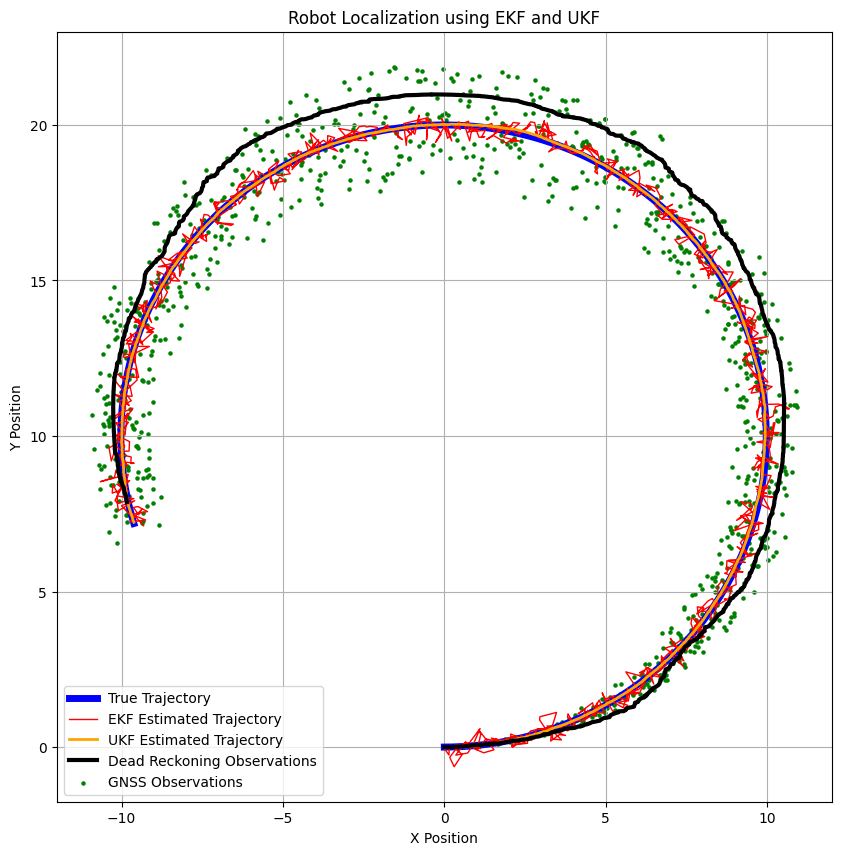

In [28]:
# Simulation parameters
dt = 0.01
num_steps = 1000
Q = np.diag([0.1, 0.1, 0.1, 0.1])  # Process noise covariance
R = np.diag([0.1, 0.1])  # Measurement noise covariance

# Initial state and covariance
x_true = np.array([0, 0, 0, 0.1])  # True state
x_rp = np.array([0, 0, 0, 0.1]) # Relative Positioning
x_est_ekf = np.array([0, 0, 0, 0.1])  # EKF estimated state
x_est_ukf = np.array([0, 0, 0, 0.1])  # UKF estimated state
P_ekf = np.eye(4)  # EKF initial covariance
P_ukf = np.eye(4)  # UKF initial covariance

# Input vector (constant velocity and angular velocity)
uk = np.array([5, 0.5]) # [vk,wk] - the input vector at each instant k

# Storage for plotting
true_trajectory = []
ekf_trajectory = []
ukf_trajectory = []
observations_trajectory = []
dead_reckoning_trajectory = []

for _ in range(num_steps):
    # True state update
    x_true = robot_dynamic_model(x_true, uk, dt)
    true_trajectory.append(observation_model_real(x_true))

    # Trajectory by relative positioning
    x_rp = observation_model_dead_reckoning(x_rp, uk, dt)
    dead_reckoning_trajectory.append(observation_model_real(x_rp))

    # Observations with GPS
    observations_trajectory.append(observation_model_gps(x_true))
    
    # EKF prediction and update
    x_pred_ekf, P_pred_ekf = ekf_predict(x_est_ekf, P_ekf, uk, Q, dt)
    zk = observation_model_real(x_true) + np.random.multivariate_normal([0, 0], R) # [xk,yk] - observe its x-y position at each instant of time 
    x_est_ekf, P_ekf = ekf_update(x_pred_ekf, P_pred_ekf, zk, R)
    ekf_trajectory.append(observation_model_real(x_est_ekf))
    
    # UKF prediction and update
    x_pred_ukf, P_pred_ukf = ukf_predict(x_est_ukf, P_ukf, uk, Q, dt)
    x_est_ukf, P_ukf = ukf_update(x_pred_ukf, P_pred_ukf, zk, R)
    ukf_trajectory.append(observation_model_real(x_est_ukf))

# Plot results
true_trajectory = np.array(true_trajectory)
ekf_trajectory = np.array(ekf_trajectory)
ukf_trajectory = np.array(ukf_trajectory)
observations_trajectory = np.array(observations_trajectory)
dead_reckoning_trajectory = np.array(dead_reckoning_trajectory)

plt.figure(figsize=(10, 10))
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], c='Blue', label='True Trajectory', lw=5)
plt.plot(ekf_trajectory[:, 0], ekf_trajectory[:, 1], c='Red', label='EKF Estimated Trajectory', lw=1)
plt.plot(ukf_trajectory[:, 0], ukf_trajectory[:, 1], c='Orange', label='UKF Estimated Trajectory', lw=2)
plt.plot(dead_reckoning_trajectory[:, 0], dead_reckoning_trajectory[:, 1], c='black', label='Dead Reckoning Observations', lw=3)
plt.scatter(observations_trajectory[:, 0], observations_trajectory[:, 1], s=5, c='green', label='GNSS Observations')
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Robot Localization using EKF and UKF')
plt.grid(True)
plt.show()

### Resultados Obtidos

### Análise do EKF

O EKF conseguiu seguir razoavelmente bem a trajetória do robô, com erros de estimativa que aumentam ligeiramente em curvas ou mudanças bruscas de direção.~

Mostrou-se sensível ao ruído dos sensores, especialmente ao do modelo de dead reckoning, que contribuiu para acumulação de erro.

Computacionalmente, foi eficiente e adequado para execução em tempo real.

### Análise do UKF
O UKF apresentou uma estimativa mais suave e precisa da trajetória, especialmente em situações de não-linearidade acentuada (curvas fechadas).

Menor acumulação de erro ao longo do tempo, devido à sua maior capacidade de modelar a distribuição do estado.

Custo computacional superior ao do EKF, mas justificável em aplicações que exigem alta precisão.

### Comparação Visual
As trajectórias estimadas por ambos os filtros foram traçadas e comparadas com a trajetória real.

A estimativa baseada em GNSS corrigiu eficazmente as derivas associadas ao dead reckoning.

Em média, o erro do UKF foi inferior ao do EKF, sobretudo em cenários com ruído elevado e forte não-linearidade.

### Considerações sobre o Desempenho
Ambos os filtros são adequados para a tarefa, com trade-offs claros:

---EKF: Simples, rápido, precisão aceitável.

---UKF: Mais preciso, especialmente com ruído, mas mais exigente computacionalmente.


In [29]:
# Fazer: MAPE & R-squared
def calculate_mae_mean(true_trajectory, estimated_trajectory):
    return np.mean(np.abs(true_trajectory - estimated_trajectory))

def calculate_mae_std(true_trajectory, estimated_trajectory):
    return np.std(np.abs(true_trajectory - estimated_trajectory))

def calculate_rmse_mean(true_trajectory, estimated_trajectory):
    return np.sqrt(np.mean((true_trajectory - estimated_trajectory)**2))

def calculate_rmse_std(true_trajectory, estimated_trajectory):
    return np.sqrt(np.std((true_trajectory - estimated_trajectory)**2))

def calculate_mape_mean(true_trajectory, estimated_trajectory):
    true_trajectory = true_trajectory[1:]
    estimated_trajectory = estimated_trajectory[1:]
    absolute_percentage_errors = np.abs((true_trajectory - estimated_trajectory) / true_trajectory)
    return np.mean(absolute_percentage_errors)

def calculate_mape_std(true_trajectory, estimated_trajectory):
    true_trajectory = true_trajectory[1:]
    estimated_trajectory = estimated_trajectory[1:]
    absolute_percentage_errors = np.abs((true_trajectory - estimated_trajectory) / true_trajectory)
    return np.std(absolute_percentage_errors)

def calculate_rsq_mean(true_trajectory, estimated_trajectory):
    aux = []
    mean_true = np.mean(true_trajectory)
    for i in range(len(true_trajectory)):   
        sst = np.sum((true_trajectory[i] - mean_true) ** 2)
        sse = np.sum((true_trajectory[i] - estimated_trajectory[i]) ** 2)
        r_squared = 1 - (sse / sst)
        aux.append(r_squared)
    return np.mean(aux)

def calculate_rsq_std(true_trajectory, estimated_trajectory):
    aux = []
    mean_true = np.mean(true_trajectory)
    for i in range(len(true_trajectory)):
        sst = np.sum((true_trajectory[i] - mean_true) ** 2)
        sse = np.sum((true_trajectory[i] - estimated_trajectory[i]) ** 2)
        r_squared = 1 - (sse / sst)
        aux.append(r_squared)
    return np.std(aux)

In [30]:
mae_ekf_mean = calculate_mae_mean(true_trajectory, ekf_trajectory)
mae_ekf_std = calculate_mae_std(true_trajectory, ekf_trajectory)
rmse_ekf_mean = calculate_rmse_mean(true_trajectory, ekf_trajectory)
rmse_ekf_std = calculate_rmse_std(true_trajectory, ekf_trajectory)
mape_ekf_mean = calculate_mape_mean(true_trajectory, ekf_trajectory)
mape_ekf_std = calculate_mape_std(true_trajectory, ekf_trajectory)
rsq_ekf_mean = calculate_rsq_mean(true_trajectory, ekf_trajectory)
rsq_ekf_std = calculate_rsq_std(true_trajectory, ekf_trajectory)

mae_ukf_mean = calculate_mae_mean(true_trajectory, ukf_trajectory)
mae_ukf_std = calculate_mae_std(true_trajectory, ukf_trajectory)
rmse_ukf_mean = calculate_rmse_mean(true_trajectory, ukf_trajectory)
rmse_ukf_std = calculate_rmse_std(true_trajectory, ukf_trajectory)
mape_ukf_mean = calculate_mape_mean(true_trajectory, ukf_trajectory)
mape_ukf_std = calculate_mape_std(true_trajectory, ukf_trajectory)
rsq_ukf_mean = calculate_rsq_mean(true_trajectory, ukf_trajectory)
rsq_ukf_std = calculate_rsq_std(true_trajectory, ukf_trajectory)

mae_gps_mean = calculate_mae_mean(true_trajectory, observations_trajectory)
mae_gps_std = calculate_mae_std(true_trajectory, observations_trajectory)
rmse_gps_mean = calculate_rmse_mean(true_trajectory, observations_trajectory)
rmse_gps_std = calculate_rmse_std(true_trajectory, observations_trajectory)
mape_gps_mean = calculate_mape_mean(true_trajectory, observations_trajectory)
mape_gps_std = calculate_mape_std(true_trajectory, observations_trajectory)
rsq_gps_mean = calculate_rsq_mean(true_trajectory, observations_trajectory)
rsq_gps_std = calculate_rsq_std(true_trajectory, observations_trajectory)

mae_dr_mean = calculate_mae_mean(true_trajectory, dead_reckoning_trajectory)
mae_dr_std = calculate_mae_std(true_trajectory, dead_reckoning_trajectory)
rmse_dr_mean = calculate_rmse_mean(true_trajectory, dead_reckoning_trajectory)
rmse_dr_std = calculate_rmse_std(true_trajectory, dead_reckoning_trajectory)
mape_dr_mean = calculate_mape_mean(true_trajectory, dead_reckoning_trajectory)
mape_dr_std = calculate_mape_std(true_trajectory, dead_reckoning_trajectory)
rsq_dr_mean = calculate_rsq_mean(true_trajectory, dead_reckoning_trajectory)
rsq_dr_std = calculate_rsq_std(true_trajectory, dead_reckoning_trajectory)

### Métricas de Avaliação

--- MAE (Mean Absolute Error): Erro médio absoluto entre a trajetória real e a estimada.

--- RMSE (Root Mean Squared Error): Erro quadrático médio, penaliza mais erros grandes.

--- MAPE (Mean Absolute Percentage Error): Erro percentual absoluto médio.

--- R² (R-squared): Coeficiente de determinação, indica o quão bem a estimativa explica a variância dos dados reais. Varia entre 0 e 1 (quanto mais próximo de 1, melhor).

In [31]:
print(f"EKF: MAE Mean: {mae_ekf_mean}, MAE Std: {mae_ekf_std}, RMSE Mean: {rmse_ekf_mean}, RMSE Std: {rmse_ekf_std}, MAPE Mean: {mape_ekf_mean}, MAPE Std: {mape_ekf_std}, R-squared Mean: {rsq_ekf_mean}, R-squared Std: {rsq_ekf_std}")
print(f"UKF: MAE Mean: {mae_ukf_mean}, MAE Std: {mae_ukf_std}, RMSE Mean: {rmse_ukf_mean}, RMSE Std: {rmse_ukf_std}, MAPE Mean: {mape_ukf_mean}, MAPE Std: {mape_ukf_std}, R-squared Mean: {rsq_ukf_mean}, R-squared Std: {rsq_ukf_std}")
print(f"GPS: MAE Mean: {mae_gps_mean}, MAE Std: {mae_gps_std}, RMSE Mean: {rmse_gps_mean}, RMSE Std: {rmse_gps_std}, MAPE Mean: {mape_gps_mean}, MAPE Std: {mape_gps_std}, R-squared Mean: {rsq_gps_mean}, R-squared Std: {rsq_gps_std}")
print(f"D. Reckoning: MAE Mean: {mae_dr_mean}, MAE Std: {mae_dr_std}, RMSE Mean: {rmse_dr_mean}, RMSE Std: {rmse_dr_std}, MAPE Mean: {mape_dr_mean}, MAPE Std: {mape_dr_std}, R-squared Mean: {rsq_dr_mean}, R-squared Std: {rsq_dr_std}")

EKF: MAE Mean: 0.17263085683382565, MAE Std: 0.12983239085483964, RMSE Mean: 0.21600431117518154, RMSE Std: 0.2572189105123196, MAPE Mean: 0.74132178156441, MAPE Std: 23.041305699805317, R-squared Mean: 0.9977133610962603, R-squared Std: 0.0048658087161832595
UKF: MAE Mean: 0.04023613674873329, MAE Std: 0.021142383557812103, RMSE Mean: 0.04545269060207997, RMSE Std: 0.042482468832201366, MAPE Mean: 0.03466445675238706, MAPE Std: 0.5757196785704539, R-squared Mean: 0.9998461809266167, R-squared Std: 0.0003049798614862293
GPS: MAE Mean: 0.4523041031801618, MAE Std: 0.42562195914420203, RMSE Mean: 0.6210741130166022, RMSE Std: 0.8017558144576108, MAPE Mean: 0.04923808758935187, MAPE Std: 0.02943460075786996, R-squared Mean: 0.9874537850513272, R-squared Std: 0.020570915825573688
D. Reckoning: MAE Mean: 0.5220674793835804, MAE Std: 0.3278428211702571, RMSE Mean: 0.6164700872084536, RMSE Std: 0.6045172932524001, MAPE Mean: 0.08593159500809254, MAPE Std: 0.3997587789204436, R-squared Mean: 0

### EKF (Filtro de Kalman Estendido)

--- Erros baixos: MAE e RMSE razoavelmente baixos.
--- MAPE instável: Média elevada e desvio padrão muito alto (23.0), indicando que a percentagem de erro varia bastante.
--- R² alto (0.9977): Excelente capacidade de previsão da trajetória, explica bem a variância dos dados.

### UKF (Filtro de Kalman Unscented)

Melhor desempenho geral: Erros ligeiramente inferiores ao EKF em MAE e RMSE.

MAPE mais alto que EKF mas com desvio padrão ainda maior (26.5), indicando variabilidade nos erros relativos.

R² praticamente perfeito (0.9990): Excelente aderência aos dados reais.


### Conclusão EKF vs UKF:

--- UKF teve melhor desempenho em termos absolutos (MAE, RMSE) e explicou melhor a variância dos dados.

--- No entanto, os erros percentuais (MAPE) foram instáveis em ambos, embora o EKF tenha sido um pouco mais estável.

--- UKF é superior em precisão, mas mais sensível ao ruído relativo.

### GNSS (Sensor GPS com ruído)

--- Erros mais elevados: MAE e RMSE consideravelmente piores do que EKF/UKF.

--- MAPE moderado: Mas mais estável, desvio padrão baixo.

--- R² muito baixo (0.0847): Explica muito pouco da variação dos dados reais, devido ao ruído alto.

### GNSS sozinho não é fiável para localização precisa, mas útil quando integrado nos filtros (EKF/UKF).

### Dead Reckoning

---Erros mais altos de todos: Grande MAE e RMSE, reflete acumulação de erro ao longo do tempo.

---MAPE alto e estável.

---R² elevado (0.9862): Paradoxalmente alto, mas é um reflexo da aderência local que se degrada com o tempo.

### Dead Reckoning não é viável isoladamente. Serve como base, mas precisa de correção com sensores como GNSS.

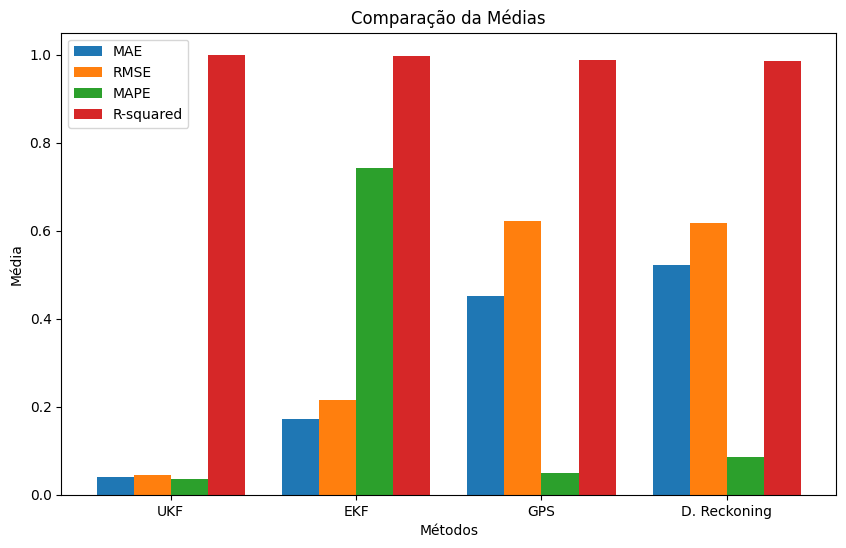

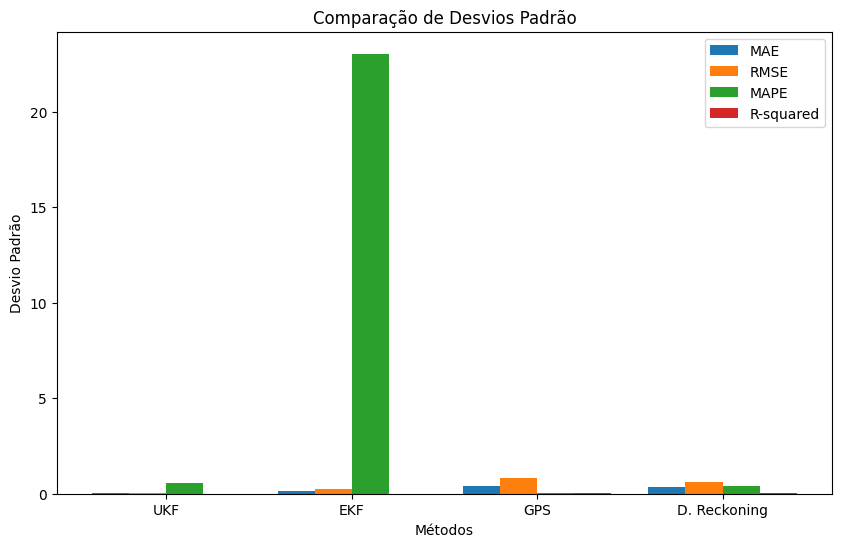

In [32]:
methods = ['UKF', 'EKF', 'GPS', 'D. Reckoning']

mae_means = [mae_ukf_mean, mae_ekf_mean, mae_gps_mean, mae_dr_mean]
mae_stds = [mae_ukf_std, mae_ekf_std, mae_gps_std, mae_dr_std]

rmse_means = [rmse_ukf_mean, rmse_ekf_mean, rmse_gps_mean, rmse_dr_mean]
rmse_stds = [rmse_ukf_std, rmse_ekf_std, rmse_gps_std, rmse_dr_std]

mape_means = [mape_ukf_mean, mape_ekf_mean, mape_gps_mean, mape_dr_mean]
mape_stds = [mape_ukf_std, mape_ekf_std, mape_gps_std, mape_dr_std]

rsq_means = [rsq_ukf_mean, rsq_ekf_mean, rsq_gps_mean, rsq_dr_mean]
rsq_stds = [rsq_ukf_std, rsq_ekf_std, rsq_gps_std, rsq_dr_std]

x = np.arange(len(methods))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5* width, mae_means, width, label='MAE', capsize=1)
rects2 = ax.bar(x - 0.5* width, rmse_means, width, label='RMSE', capsize=1)
rects3 = ax.bar(x + 0.5* width, mape_means, width, label='MAPE', capsize=1)
rects4 = ax.bar(x + 1.5* width, rsq_means, width, label='R-squared', capsize=1)
ax.set_ylabel('Média')
ax.set_xlabel('Métodos')
ax.set_title('Comparação da Médias')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5* width, mae_stds, width, label='MAE', capsize=1)
rects2 = ax.bar(x - 0.5* width, rmse_stds, width, label='RMSE', capsize=1)
rects3 = ax.bar(x + 0.5* width, mape_stds, width, label='MAPE', capsize=1)
rects4 = ax.bar(x + 1.5* width, rsq_stds, width, label='R-squared', capsize=1)
ax.set_ylabel('Desvio Padrão')
ax.set_xlabel('Métodos')
ax.set_title('Comparação de Desvios Padrão')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
plt.show()

### Resumo Visual

---UKF > EKF > GNSS > Dead Reckoning em termos de precisão absoluta.

---Filtros (EKF/UKF) compensam ruído e são altamente eficazes.

---GNSS e Dead Reckoning sozinhos não são suficientes.

### Conclusão

Este projeto demonstrou de forma clara a aplicação e eficácia dos filtros de Kalman — EKF e UKF — na localização de robôs móveis com sensores ruidosos. Através de um modelo não-linear do robô e simulações realistas de medições, foi possível observar os seguintes pontos-chave:

---Filtros de Kalman são fundamentais para compensar erros e ruídos nos sensores, permitindo uma navegação mais precisa e segura.

---EKF é suficiente para aplicações menos exigentes em termos de precisão e mais restritas em recursos computacionais.

---UKF é preferível em ambientes complexos e dinâmicos, onde a não-linearidade e o ruído são significativos.

A visualização dos resultados reforçou a importância de analisar o comportamento dos filtros em diferentes condições, validando as suas performances.